In [1]:
import os
import cv2 as cv
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import pandas as pd
import torch.nn.functional as F
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score
from scipy.stats import ttest_rel
from torch.utils.data import Dataset, DataLoader
!pip install pretrainedmodels
!pip install efficientnet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=46da979ba52e35d6f743ad9508bc090d48436bf6ba6c33b7e05c57879bbe9b4c
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built pretrainedmodels
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=f180352ea2564c10650f190f7d69220b119315f546f2328fcfca4f18d528a111
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [2]:
from google.colab import drive
drive_dir = drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir = '/content/drive/My Drive/mp'
weight_dir = '/content/drive/My Drive/clam_weights/pre-trained_weights'
model_dir = '/content/drive/My Drive/MP-Net/src/segmentation_models/segmentation_models_pytorch'
root_dir = "/content/drive/My Drive/MP-Net/src/segmentation_models"
images_dir = os.path.join(data_dir, 'images')
masks_dir = os.path.join(data_dir, 'masks')
unet_dir = os.path.join(model_dir, 'unet')
resized_images_dir = os.path.join(data_dir, 'resized_images')
resized_masks_dir = os.path.join(data_dir, 'resized_masks')
inverted_resized_masks_dir = os.path.join(data_dir, 'inverted_resized_masks')

# Unet

In [4]:
import sys
from importlib import import_module

if root_dir not in sys.path:
    sys.path.append(root_dir)

# 3. Check existence
if not os.path.isdir(unet_dir):
    print(f"Error: The 'unet' directory was not found at '{unet_dir}'.")
    sys.exit(1)

from segmentation_models_pytorch.unet.model import Unet

# Dynamically import the UNet class from unet.model
try:
    unet_model = import_module('segmentation_models_pytorch.unet.model')
    UNet = getattr(unet_model, 'Unet')  # or 'UNet' if spelled that way
except ModuleNotFoundError as e:
    print(f"Error importing the Unet model: {e}")
    sys.exit(1)
except AttributeError:
    print("Error: The 'Unet' class was not found in 'model.py'.")
    sys.exit(1)

model = UNet(encoder_name="resnet101",     # <-- Must match your checkpoint’s encoder
    encoder_weights=None,         # or "imagenet" if that was used
    in_channels=3,                # checkpoint also shows 3-channel input (conv1 has shape [64,3,7,7])
    classes=1)                     # checkpoint’s segmentation head has out_channels=1

#model_dict = model.load_state_dict(torch.load(os.path.join(weight_dir,'unet4.pth'), map_location='cpu'), strict=False)

#checkpoint = torch.load(os.path.join(weight_dir, 'unet4.pth'), map_location='cpu')
#print(checkpoint.keys())  # see what’s inside

model.load_state_dict(
    torch.load(os.path.join(weight_dir, 'unet4.pth'), map_location='cpu'),
    )

# Set to evaluation mode (if using for inference)
model.eval()

<ipython-input-4-dbb2f5fdd7f8>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(weight_dir, 'unet4.pth'), map_location='cpu'),


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

# Resizing and saving to Drive

In [5]:
for dir in [images_dir, masks_dir]:
  for i, img_name in enumerate(os.listdir(dir)):
    image_path = os.path.join(dir, img_name)
    img = cv.imread(image_path)
    resized_img = cv.resize(img, (256, 256), interpolation=cv.INTER_AREA)

    cv.imwrite(os.path.join(resized_images_dir if "images" in dir else resized_masks_dir, img_name), resized_img)

# Utilities

In [5]:
def show_image(img, cmap='gray'):
  plt.imshow(img, cmap=cmap)
  plt.show()

def show_all_images(*images):
  fig = plt.figure(figsize=(10, 7))
  # setting values to rows and column variables
  rows = 1
  columns = len(images)
  for i, image in enumerate(images):
    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, i + 1)

    # showing image
    plt.imshow(image, cmap='gray')
    plt.axis('off')

def show_images(labels, *images):
  fig = plt.figure(figsize=(10, 7))
  # setting values to rows and column variables
  rows = 1
  columns = len(images)

  for i, image in enumerate(images):
    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, i + 1)

    # showing image
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(labels[i] if i + 1 <= len(labels) else i)

In [6]:
from PIL import Image
def save_numpy_as_image(array, path):
    """
    Saves a numpy array as an image.

    Parameters:
        array (numpy.ndarray): The image data as a numpy array.
        path (str): The path where the image will be saved.
    """
    # If the image is binary (i.e., has a shape like (256, 256, 1)),
    # we should first remove the singleton dimension before saving it
    if array.ndim == 3 and array.shape[-1] == 1:
        array = array.squeeze(-1)

    # Convert the numpy array to a PIL image
    image = Image.fromarray(np.uint8(array * 255))

    # Save the image
    image.save(path)

    print(f"Image saved as {path}")

# Inverting masks for the model

In [7]:
import os
from PIL import Image, ImageOps

# Define the folder containing the images and the output folder
input_folder = resized_masks_dir
output_folder = inverted_resized_masks_dir

# Loop through all files in the input folder
for filename in os.listdir(input_folder):
    # Check if the file is an image
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        try:
            # Load the image
            image = Image.open(input_path).convert("L")  # Convert to grayscale

            # Invert the colors
            inverted_image = ImageOps.invert(image)

            # Save the inverted image to the output folder
            inverted_image.save(output_path)

            print(f"Processed: {filename}")
        except Exception as e:
            print(f"Failed to process {filename}: {e}")

print("Batch processing completed!")


Processed: 20211223105352.jpg
Processed: 20211223105328.jpg
Processed: 20211223105558.jpg
Processed: 20211223105246.jpg
Processed: 20211223105413.jpg
Processed: 20211223105341.jpg
Processed: 20211223105115.jpg
Processed: 20211223105218.jpg
Processed: 20211223105043.jpg
Processed: 20211223105434.jpg
Processed: 20211223105234.jpg
Processed: 20211223105511.jpg
Processed: 20211223105604.jpg
Processed: 20211223105958.jpg
Processed: 20211223105753.jpg
Processed: 20211223110033.jpg
Processed: 20211223110228.jpg
Processed: 20211223105651.jpg
Processed: 20211223105854.jpg
Processed: 20211223105906.jpg
Processed: 20211223105713.jpg
Processed: 20211223110027.jpg
Processed: 20211223110056.jpg
Processed: 20211223110141.jpg
Processed: 20211223110252.jpg
Processed: 20211223105822.jpg
Processed: 20211223110007.jpg
Processed: 20211223105835.jpg
Processed: 20211223110044.jpg
Processed: 20211223105616.jpg
Processed: 20211223105845.jpg
Processed: 20211223110152.jpg
Processed: 20211223105723.jpg
Processed:

# Loading

In [15]:
def load_images_and_masks(images_dir, masks_dir):
  images_arr = []
  masks_arr = []
  for i, img_name in enumerate(os.listdir(masks_dir)):
    image_path = os.path.join(images_dir, img_name)
    mask_path = image_path.replace(images_dir, masks_dir)
    img = cv.imread(image_path)

    if (os.path.isfile(mask_path)):
      mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
      mask = np.expand_dims(mask, axis=-1)
      images_arr.append(img)
      masks_arr.append(mask)

  return (images_arr, masks_arr)

(raw_images, raw_masks) = load_images_and_masks(resized_images_dir, inverted_resized_masks_dir)

In [8]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.image_names = os.listdir(masks_dir)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        image_path = os.path.join(self.images_dir, img_name)
        mask_path = os.path.join(self.masks_dir, img_name)

        # Load image and mask
        img = cv.imread(image_path)
        mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension for mask

        # Apply transformations if any
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        # Convert to PyTorch tensors
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # HWC -> CHW
        mask = torch.tensor(mask, dtype=torch.float32).permute(2, 0, 1)  # HWC -> CHW

        return img, mask

# Define dataset and DataLoader
dataset = SegmentationDataset(resized_images_dir, inverted_resized_masks_dir)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Statistics

In [9]:
# Helper function for metrics calculation
def calculate_metrics(y_true, y_pred, threshold=0.8):
    """
    y_true: (1, H, W) or (H, W) in [0, 1]
    y_pred: (1, H, W) or (H, W) in [0, 1] (probabilities)

    1) Remove any leading channel dimension.
    2) Threshold y_pred.
    3) Flatten and compute metrics for binary segmentation.
    """

    # Squeeze out leading channel if present (i.e., shape (1, H, W))
    if y_true.ndim == 3 and y_true.shape[0] == 1:
        y_true = y_true.squeeze(0)  # from (1, H, W) to (H, W)
    if y_pred.ndim == 3 and y_pred.shape[0] == 1:
        y_pred = y_pred.squeeze(0)  # from (1, H, W) to (H, W)

    # Threshold predictions
    y_pred_bin = (y_pred > threshold).astype(np.uint8)

    # Flatten
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred_bin.flatten()

    # Compute metrics
    accuracy = accuracy_score(y_true_flat, y_pred_flat)
    precision = precision_score(y_true_flat, y_pred_flat, average="binary", zero_division=1)
    recall = recall_score(y_true_flat, y_pred_flat, average="binary", zero_division=1)
    f1 = f1_score(y_true_flat, y_pred_flat, average="binary", zero_division=1)
    iou = jaccard_score(y_true_flat, y_pred_flat, average="binary", zero_division=1)

    return accuracy, precision, recall, f1, iou


def test_model_and_calculate_statistics(model, dataloader, device="cuda", threshold=0.8):
    """
    Evaluate a binary segmentation model over the given dataloader.
    Returns a dict with mean metrics across all batches/images.
    """
    model.eval()

    # Accumulate batch-wise metrics
    metrics = {
        "accuracy": [],
        "precision": [],
        "recall": [],
        "f1": [],
        "iou": []
    }

    # Disable gradient calculation
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)

            # Forward pass
            outputs = model(images)
            # Apply sigmoid to get probabilities in [0,1], then move to CPU
            preds = torch.sigmoid(outputs).cpu().numpy()

            # Move masks to CPU and binarize them (assuming > 0 is foreground)
            masks = masks.cpu().numpy()
            masks_bin = (masks > 0).astype(np.uint8)  # shape (B, 1, H, W) or (B, H, W)

            # Compute metrics for each image in the batch
            for i in range(len(masks_bin)):
                acc, prec, rec, f1, iou = calculate_metrics(
                    masks_bin[i],
                    preds[i],  # shape (1, H, W) or (H, W)
                    threshold=threshold
                )
                metrics["accuracy"].append(acc)
                metrics["precision"].append(prec)
                metrics["recall"].append(rec)
                metrics["f1"].append(f1)
                metrics["iou"].append(iou)

    # Mean metrics across the entire dataset
    mean_metrics = {key: np.mean(value) for key, value in metrics.items()}
    return mean_metrics




# Visualizing

In [10]:
def visualize_sample(image, mask_bin, pred_bin):
    """
    image:  Tensor or NumPy array of shape (C, H, W) or (H, W).
    mask_bin: (H, W) in {0,1}.
    pred_bin: (H, W) in {0,1}.
    """

    # Convert PyTorch tensor to NumPy if needed
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()

    # If image has shape (C, H, W), handle channels:
    if image.ndim == 3:
        if image.shape[0] == 1:
            # Single channel: squeeze out the C dimension
            image = image.squeeze(0)  # becomes (H, W)
        elif image.shape[0] == 3:
            # 3-channel: transpose to (H, W, 3) for RGB
            image = np.transpose(image, (1, 2, 0))

    # Now `image` is either (H, W) [grayscale] or (H, W, 3) [RGB].
    # If it's (H, W, 1), we can squeeze once more:
    if image.ndim == 3 and image.shape[2] == 1:
        image = np.squeeze(image, axis=-1)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 1) Original Image
    # If it's 2D, use cmap='gray'. If 3D, let matplotlib guess.
    if image.ndim == 2:
        axes[0].imshow(image, cmap="gray")
    else:
        axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # 2) Ground-Truth Mask (H, W) in {0, 1}
    axes[1].imshow(mask_bin, cmap="gray")
    axes[1].set_title("Ground-Truth Mask")
    axes[1].axis("off")

    # 3) Predicted Mask (H, W) in {0, 1}
    axes[2].imshow(pred_bin, cmap="gray")
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

In [11]:
def visualize_batch(model, dataloader, device="cuda", threshold=0.5):
    model.eval()

    # Just take one batch
    images, masks = next(iter(dataloader))
    images = images.to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = torch.sigmoid(outputs).cpu().numpy()

    # Visualize the first sample in the batch
    idx = 0

    # 1) Original image
    img_np = images[idx]  # shape (C, H, W) on GPU
    # 2) Ground truth mask
    mask_np = masks[idx].cpu().numpy()  # shape could be (H, W) or (1, H, W)
    mask_bin = (mask_np > 0).astype(np.uint8)  # ensure 0 or 1
    # 3) Prediction
    pred_np = preds[idx]  # shape (1, H, W) or (H, W)
    if pred_np.ndim == 3 and pred_np.shape[0] == 1:
        pred_np = pred_np.squeeze(0)
    pred_bin = (pred_np > threshold).astype(np.uint8)

    visualize_sample(img_np, mask_bin, pred_bin)

TypeError: Invalid shape (1, 256, 256) for image data

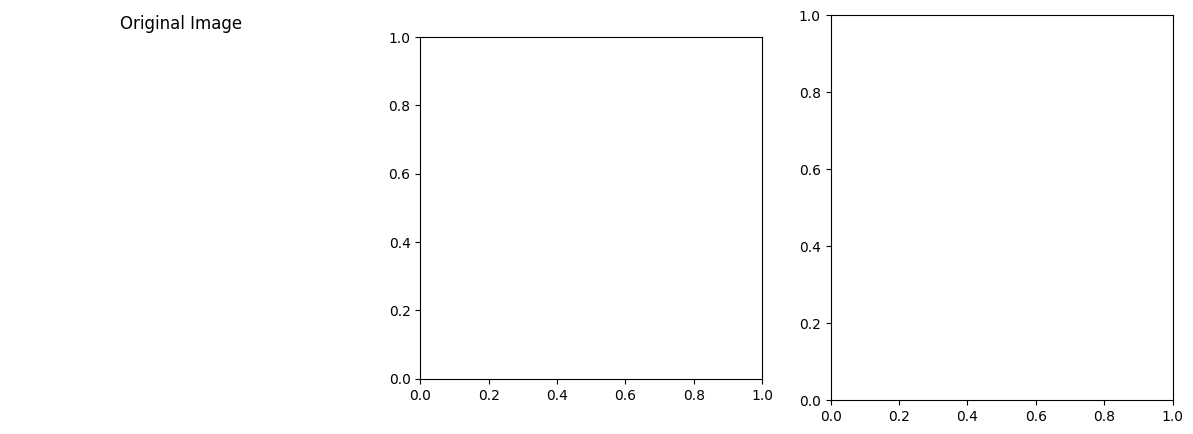

In [12]:
%matplotlib inline

# Now call the function:
visualize_batch(
    model=model,
    dataloader=dataloader,
    device="cpu",    # or "cpu", depending on your setup
    threshold=0.5     # threshold for converting probabilities to 0/1
)

# Executing and table creating

In [44]:
# Example usage
# Assuming `test_dataloader` is your DataLoader with test data
# and `model` is your trained PyTorch model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
mean_metrics = test_model_and_calculate_statistics(model, dataloader, device=device)

# Print the results
print("Mean Metrics:", mean_metrics)
#print("P-Value:", p_value)

Mean Metrics: {'accuracy': 0.9984032415574596, 'precision': 0.9985151646375878, 'recall': 0.9998874818424989, 'f1': 0.9991953598640486, 'iou': 0.9984031274194538}


In [12]:
import pandas as pd
from tabulate import tabulate  # Optional, for a nice CLI table

def print_metrics_table(metrics_dict):
    """
    Print metrics in a tabular format using pandas DataFrame.
    """
    # Create a DataFrame from the metrics dictionary
    metrics_df = pd.DataFrame([metrics_dict])

    # Print as a table
    print("Metrics Table:")
    print(tabulate(metrics_df, headers="keys", tablefmt="grid"))


# Example Usage in Model Testing
mean_metrics = {
    "Accuracy": 0.9984041124064632,
    "Precision": 0.9985147215265792,
    "Recall": 0.9998888119327677,
    "F1-Score": 0.9991957977679148,
    "IoU": 0.9984040054103518
}

# Call the function to display metrics
print_metrics_table(mean_metrics)

Metrics Table:
+----+------------+-------------+----------+------------+----------+
|    |   Accuracy |   Precision |   Recall |   F1-Score |      IoU |
+====+============+=============+==========+============+==========+
|  0 |   0.998404 |    0.998515 | 0.999889 |   0.999196 | 0.998404 |
+----+------------+-------------+----------+------------+----------+
